In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import CLIPVisionModel, CLIPProcessor
import os
import torch
import torchvision
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import os

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [57]:
CONFIG = {
    "batch_size": 32,
    "epochs": 100,
    "lr": 1e-3,
    "temperature": 0.5,
    "proj_dim": 128
}

In [28]:
class CLIPVisionSSL(nn.Module):
    """
    A self-supervised model that uses the CLIP ViT encoder as the backbone,
    plus a small projection MLP on top for contrastive learning.
    """
    def __init__(self, backbone_name="openai/clip-vit-base-patch32", proj_dim=128):
        super().__init__()
        # Load only the vision encoder (no text encoder)
        self.clip_vision = CLIPVisionModel.from_pretrained(backbone_name)
        vision_hidden_dim = self.clip_vision.config.hidden_size  # e.g. 768 for ViT-B/32

        # Projection head: (vision_hidden_dim) -> 256 -> (proj_dim)
        self.projection_head = nn.Sequential(
            nn.Linear(vision_hidden_dim, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, proj_dim),
        )

    def forward(self, x):
        """
        Returns:
          - feats: the L2-normalized feature from the last hidden state [CLS] token
          - proj: the L2-normalized projection for contrastive training
        """
        # 1) Run CLIP's vision encoder
        outputs = self.clip_vision(pixel_values=x)
        # The final CLS embedding is 'pooler_output' for CLIPVisionModel
        cls_emb = outputs.pooler_output  # shape: (B, hidden_dim)

        # 2) Projection head
        proj = self.projection_head(cls_emb)

        # 3) Normalize
        feats = F.normalize(cls_emb, dim=-1)
        proj  = F.normalize(proj, dim=-1)
        return feats, proj


In [29]:
class SimCLRDataset(Dataset):
    """
    Returns two augmented views of the same image for SimCLR.
    """
    def __init__(self, df, img_dir, transform):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_id = self.df.iloc[idx]["file_id"]
        img_path = os.path.join(self.img_dir, f"{file_id}.jpg")
        image = Image.open(img_path).convert("RGB")

        # Two augmented views
        x1 = self.transform(image)
        x2 = self.transform(image)

        return x1, x2


In [30]:
########################
# 1) Define the dataset
########################
class TrainImageDataset(Dataset):
    """
    Reads file IDs from train.csv and loads images from /kaggle/input/ucu-computer-vision-2024/train.
    Ignores labels for now, because we only want to compute mean and std.
    """
    def __init__(self, csv_path, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.image_df = pd.read_csv(csv_path)  # Must have 'file_id' column

    def __len__(self):
        return len(self.image_df)

    def __getitem__(self, idx):
        file_id = self.image_df.loc[idx, 'file_id']
        img_path = os.path.join(self.img_dir, f"{file_id}.jpg")
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

###########################
# 2) Create dataset/loader
###########################
train_csv = "/kaggle/input/ucu-computer-vision-2024/train.csv"
train_img_dir = "/kaggle/input/ucu-computer-vision-2024/train"

# Only resize + toTensor (NO normalization)
temp_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_ds = TrainImageDataset(
    csv_path=train_csv,
    img_dir=train_img_dir,
    transform=temp_transform
)

train_loader = DataLoader(
    train_ds,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

###########################
# 3) Define mean/std function
###########################
def compute_mean_std(data_loader):
    channel_sum = torch.zeros(3)
    channel_sq_sum = torch.zeros(3)
    num_pixels = 0
    
    for images in data_loader:
        # images shape: (B, 3, H, W)
        B, C, H, W = images.shape
        
        # Flatten the spatial dims so we can sum easily
        images = images.view(B, C, -1)  # => (B, 3, H*W)
        
        channel_sum += images.sum(dim=[0,2])
        channel_sq_sum += (images ** 2).sum(dim=[0,2])
        num_pixels += B * H * W

    mean = channel_sum / num_pixels
    std = torch.sqrt(channel_sq_sum / num_pixels - mean ** 2)
    return mean, std

###########################
# 4) Compute and print
###########################
mean, std = compute_mean_std(train_loader)
print("Mean =", mean)
print("Std  =", std)


Mean = tensor([0.5659, 0.5438, 0.5094])
Std  = tensor([0.3031, 0.3019, 0.3209])


In [31]:
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.ColorJitter(0.4,0.4,0.4,0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5659, 0.5438, 0.5094],
        std=[0.3031, 0.3019, 0.3209]
    ),
])


In [32]:
def simclr_contrastive_loss(z1, z2, temperature=0.5):
    """
    SimCLR InfoNCE loss between two augmented batches z1, z2.
    z1, z2: [B, proj_dim]
    """
    batch_size = z1.size(0)

    # Combine z1, z2
    z = torch.cat([z1, z2], dim=0)  # shape: (2B, proj_dim)

    # Compute similarity matrix
    sim = torch.mm(z, z.t())  # (2B, 2B)
    sim /= temperature

    # Mask out self-sim
    mask = torch.eye(2*batch_size, dtype=torch.bool, device=z.device)
    sim = sim.masked_fill(mask, float('-inf'))

    # For each z1_i, the positive is z2_i; for z2_i, the positive is z1_i
    targets = torch.cat([
        torch.arange(batch_size, 2*batch_size),
        torch.arange(batch_size)
    ], dim=0).to(z.device)

    loss = F.cross_entropy(sim, targets)
    return loss


In [33]:
inference_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5659, 0.5438, 0.5094],
        std=[0.3031, 0.3019, 0.3209]
    ),
])


In [10]:
train_df = pd.read_csv("/kaggle/input/ucu-computer-vision-2024/train.csv")
train_img_dir = "/kaggle/input/ucu-computer-vision-2024/train"

simclr_dataset = SimCLRDataset(train_df, train_img_dir, transform=train_transform)
simclr_loader = DataLoader(simclr_dataset, batch_size=CONFIG["batch_size"], shuffle=True, num_workers=2)


In [58]:
model_ssl = CLIPVisionSSL(
    proj_dim=CONFIG["proj_dim"]
).to(device)

optimizer = optim.Adam(model_ssl.parameters(), lr=CONFIG["lr"])

for epoch in range(1, CONFIG["epochs"]+1):
    model_ssl.train()
    total_loss = 0.0
    for x1, x2 in tqdm(simclr_loader, desc=f"Epoch {epoch}/{CONFIG['epochs']}"):
        x1, x2 = x1.to(device), x2.to(device)

        # Forward pass
        _, z1 = model_ssl(x1)
        _, z2 = model_ssl(x2)

        # Compute SimCLR loss
        loss = simclr_contrastive_loss(z1, z2, temperature=CONFIG["temperature"])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(simclr_loader)
    print(f"Epoch {epoch} - Loss: {avg_loss:.4f}")

# Save model
os.makedirs("simclr_ckpt", exist_ok=True)
torch.save(model_ssl.state_dict(), "simclr_ckpt/model_ssl.pth")


Epoch 1/100: 100%|██████████| 113/113 [00:50<00:00,  2.24it/s]


Epoch 1 - Loss: 4.0510


Epoch 2/100: 100%|██████████| 113/113 [00:47<00:00,  2.39it/s]


Epoch 2 - Loss: 3.9823


Epoch 3/100: 100%|██████████| 113/113 [00:47<00:00,  2.40it/s]


Epoch 3 - Loss: 4.0856


Epoch 4/100: 100%|██████████| 113/113 [00:49<00:00,  2.31it/s]


Epoch 4 - Loss: 4.1331


Epoch 5/100: 100%|██████████| 113/113 [00:48<00:00,  2.33it/s]


Epoch 5 - Loss: 4.1295


Epoch 6/100: 100%|██████████| 113/113 [00:48<00:00,  2.32it/s]


Epoch 6 - Loss: 4.1350


Epoch 7/100: 100%|██████████| 113/113 [00:47<00:00,  2.36it/s]


Epoch 7 - Loss: 4.1350


Epoch 8/100: 100%|██████████| 113/113 [00:48<00:00,  2.34it/s]


Epoch 8 - Loss: 4.1350


Epoch 9/100: 100%|██████████| 113/113 [00:48<00:00,  2.34it/s]


Epoch 9 - Loss: 4.1350


Epoch 10/100: 100%|██████████| 113/113 [00:47<00:00,  2.36it/s]


Epoch 10 - Loss: 4.1350


Epoch 11/100: 100%|██████████| 113/113 [00:48<00:00,  2.34it/s]


Epoch 11 - Loss: 4.1350


Epoch 12/100: 100%|██████████| 113/113 [00:49<00:00,  2.30it/s]


Epoch 12 - Loss: 4.1350


Epoch 13/100: 100%|██████████| 113/113 [00:49<00:00,  2.26it/s]


Epoch 13 - Loss: 4.1350


Epoch 14/100: 100%|██████████| 113/113 [00:49<00:00,  2.30it/s]


Epoch 14 - Loss: 4.1350


Epoch 15/100: 100%|██████████| 113/113 [00:49<00:00,  2.29it/s]


Epoch 15 - Loss: 4.1350


Epoch 16/100: 100%|██████████| 113/113 [00:47<00:00,  2.36it/s]


Epoch 16 - Loss: 4.1350


Epoch 17/100: 100%|██████████| 113/113 [00:48<00:00,  2.32it/s]


Epoch 17 - Loss: 4.1350


Epoch 18/100: 100%|██████████| 113/113 [00:49<00:00,  2.29it/s]


Epoch 18 - Loss: 4.1350


Epoch 19/100: 100%|██████████| 113/113 [00:49<00:00,  2.29it/s]


Epoch 19 - Loss: 4.1350


Epoch 20/100: 100%|██████████| 113/113 [00:50<00:00,  2.25it/s]


Epoch 20 - Loss: 4.1350


Epoch 21/100: 100%|██████████| 113/113 [00:49<00:00,  2.27it/s]


Epoch 21 - Loss: 4.1350


Epoch 22/100: 100%|██████████| 113/113 [00:48<00:00,  2.32it/s]


Epoch 22 - Loss: 4.1350


Epoch 23/100: 100%|██████████| 113/113 [00:48<00:00,  2.34it/s]


Epoch 23 - Loss: 4.1350


Epoch 24/100: 100%|██████████| 113/113 [00:48<00:00,  2.32it/s]


Epoch 24 - Loss: 4.1350


Epoch 25/100: 100%|██████████| 113/113 [00:48<00:00,  2.35it/s]


Epoch 25 - Loss: 4.1350


Epoch 26/100: 100%|██████████| 113/113 [00:49<00:00,  2.29it/s]


Epoch 26 - Loss: 4.1350


Epoch 27/100: 100%|██████████| 113/113 [00:48<00:00,  2.33it/s]


Epoch 27 - Loss: 4.1350


Epoch 28/100: 100%|██████████| 113/113 [00:49<00:00,  2.29it/s]


Epoch 28 - Loss: 4.1350


Epoch 29/100: 100%|██████████| 113/113 [00:48<00:00,  2.32it/s]


Epoch 29 - Loss: 4.1350


Epoch 30/100: 100%|██████████| 113/113 [00:49<00:00,  2.28it/s]


Epoch 30 - Loss: 4.1350


Epoch 31/100: 100%|██████████| 113/113 [00:47<00:00,  2.36it/s]


Epoch 31 - Loss: 4.1350


Epoch 32/100: 100%|██████████| 113/113 [00:48<00:00,  2.32it/s]


Epoch 32 - Loss: 4.1350


Epoch 33/100: 100%|██████████| 113/113 [00:49<00:00,  2.29it/s]


Epoch 33 - Loss: 4.1350


Epoch 34/100: 100%|██████████| 113/113 [00:48<00:00,  2.35it/s]


Epoch 34 - Loss: 4.1350


Epoch 35/100: 100%|██████████| 113/113 [00:48<00:00,  2.32it/s]


Epoch 35 - Loss: 4.1349


Epoch 36/100: 100%|██████████| 113/113 [00:48<00:00,  2.33it/s]


Epoch 36 - Loss: 4.1349


Epoch 37/100: 100%|██████████| 113/113 [00:48<00:00,  2.34it/s]


Epoch 37 - Loss: 4.1349


Epoch 38/100: 100%|██████████| 113/113 [00:49<00:00,  2.28it/s]


Epoch 38 - Loss: 4.0225


Epoch 39/100: 100%|██████████| 113/113 [00:49<00:00,  2.30it/s]


Epoch 39 - Loss: 3.9617


Epoch 40/100: 100%|██████████| 113/113 [00:47<00:00,  2.40it/s]


Epoch 40 - Loss: 3.8994


Epoch 41/100: 100%|██████████| 113/113 [00:47<00:00,  2.37it/s]


Epoch 41 - Loss: 4.1336


Epoch 42/100: 100%|██████████| 113/113 [00:48<00:00,  2.35it/s]


Epoch 42 - Loss: 4.0906


Epoch 43/100: 100%|██████████| 113/113 [00:49<00:00,  2.30it/s]


Epoch 43 - Loss: 4.1329


Epoch 44/100: 100%|██████████| 113/113 [00:48<00:00,  2.32it/s]


Epoch 44 - Loss: 3.9689


Epoch 45/100: 100%|██████████| 113/113 [00:49<00:00,  2.28it/s]


Epoch 45 - Loss: 3.9318


Epoch 46/100: 100%|██████████| 113/113 [00:48<00:00,  2.35it/s]


Epoch 46 - Loss: 3.9644


Epoch 47/100: 100%|██████████| 113/113 [00:49<00:00,  2.28it/s]


Epoch 47 - Loss: 3.9536


Epoch 48/100: 100%|██████████| 113/113 [00:48<00:00,  2.33it/s]


Epoch 48 - Loss: 3.9166


Epoch 49/100: 100%|██████████| 113/113 [00:49<00:00,  2.28it/s]


Epoch 49 - Loss: 3.9162


Epoch 50/100: 100%|██████████| 113/113 [00:48<00:00,  2.31it/s]


Epoch 50 - Loss: 3.9514


Epoch 51/100: 100%|██████████| 113/113 [00:49<00:00,  2.29it/s]


Epoch 51 - Loss: 3.9359


Epoch 52/100: 100%|██████████| 113/113 [00:48<00:00,  2.32it/s]


Epoch 52 - Loss: 3.9215


Epoch 53/100: 100%|██████████| 113/113 [00:48<00:00,  2.33it/s]


Epoch 53 - Loss: 3.9085


Epoch 54/100: 100%|██████████| 113/113 [00:49<00:00,  2.28it/s]


Epoch 54 - Loss: 3.9071


Epoch 55/100: 100%|██████████| 113/113 [00:50<00:00,  2.26it/s]


Epoch 55 - Loss: 3.8859


Epoch 56/100: 100%|██████████| 113/113 [00:48<00:00,  2.31it/s]


Epoch 56 - Loss: 3.8623


Epoch 57/100: 100%|██████████| 113/113 [00:48<00:00,  2.35it/s]


Epoch 57 - Loss: 3.8660


Epoch 58/100: 100%|██████████| 113/113 [00:48<00:00,  2.35it/s]


Epoch 58 - Loss: 3.8553


Epoch 59/100: 100%|██████████| 113/113 [00:49<00:00,  2.30it/s]


Epoch 59 - Loss: 3.8558


Epoch 60/100: 100%|██████████| 113/113 [00:48<00:00,  2.31it/s]


Epoch 60 - Loss: 3.8579


Epoch 61/100: 100%|██████████| 113/113 [00:48<00:00,  2.33it/s]


Epoch 61 - Loss: 3.8398


Epoch 62/100: 100%|██████████| 113/113 [00:48<00:00,  2.31it/s]


Epoch 62 - Loss: 3.8570


Epoch 63/100: 100%|██████████| 113/113 [00:48<00:00,  2.34it/s]


Epoch 63 - Loss: 3.9461


Epoch 64/100: 100%|██████████| 113/113 [00:49<00:00,  2.30it/s]


Epoch 64 - Loss: 3.8501


Epoch 65/100: 100%|██████████| 113/113 [00:49<00:00,  2.31it/s]


Epoch 65 - Loss: 3.8262


Epoch 66/100: 100%|██████████| 113/113 [00:48<00:00,  2.31it/s]


Epoch 66 - Loss: 3.8516


Epoch 67/100: 100%|██████████| 113/113 [00:48<00:00,  2.33it/s]


Epoch 67 - Loss: 3.8136


Epoch 68/100: 100%|██████████| 113/113 [00:49<00:00,  2.28it/s]


Epoch 68 - Loss: 3.7940


Epoch 69/100: 100%|██████████| 113/113 [00:48<00:00,  2.35it/s]


Epoch 69 - Loss: 3.8008


Epoch 70/100: 100%|██████████| 113/113 [00:49<00:00,  2.30it/s]


Epoch 70 - Loss: 3.8261


Epoch 71/100: 100%|██████████| 113/113 [00:49<00:00,  2.30it/s]


Epoch 71 - Loss: 3.7936


Epoch 72/100: 100%|██████████| 113/113 [00:48<00:00,  2.31it/s]


Epoch 72 - Loss: 3.7960


Epoch 73/100: 100%|██████████| 113/113 [00:49<00:00,  2.28it/s]


Epoch 73 - Loss: 3.8212


Epoch 74/100: 100%|██████████| 113/113 [00:49<00:00,  2.28it/s]


Epoch 74 - Loss: 3.8109


Epoch 75/100: 100%|██████████| 113/113 [00:48<00:00,  2.33it/s]


Epoch 75 - Loss: 3.7998


Epoch 76/100: 100%|██████████| 113/113 [00:48<00:00,  2.31it/s]


Epoch 76 - Loss: 3.7798


Epoch 77/100: 100%|██████████| 113/113 [00:48<00:00,  2.31it/s]


Epoch 77 - Loss: 3.7797


Epoch 78/100: 100%|██████████| 113/113 [00:49<00:00,  2.28it/s]


Epoch 78 - Loss: 3.7902


Epoch 79/100: 100%|██████████| 113/113 [00:48<00:00,  2.34it/s]


Epoch 79 - Loss: 3.7804


Epoch 80/100: 100%|██████████| 113/113 [00:48<00:00,  2.34it/s]


Epoch 80 - Loss: 3.7844


Epoch 81/100: 100%|██████████| 113/113 [00:49<00:00,  2.28it/s]


Epoch 81 - Loss: 3.7711


Epoch 82/100: 100%|██████████| 113/113 [00:49<00:00,  2.28it/s]


Epoch 82 - Loss: 3.7589


Epoch 83/100: 100%|██████████| 113/113 [00:48<00:00,  2.32it/s]


Epoch 83 - Loss: 3.7556


Epoch 84/100: 100%|██████████| 113/113 [00:48<00:00,  2.34it/s]


Epoch 84 - Loss: 3.7534


Epoch 85/100: 100%|██████████| 113/113 [00:48<00:00,  2.31it/s]


Epoch 85 - Loss: 3.7644


Epoch 86/100: 100%|██████████| 113/113 [00:48<00:00,  2.35it/s]


Epoch 86 - Loss: 3.7784


Epoch 87/100: 100%|██████████| 113/113 [00:49<00:00,  2.30it/s]


Epoch 87 - Loss: 3.7562


Epoch 88/100: 100%|██████████| 113/113 [00:48<00:00,  2.31it/s]


Epoch 88 - Loss: 3.7375


Epoch 89/100: 100%|██████████| 113/113 [00:49<00:00,  2.27it/s]


Epoch 89 - Loss: 3.7588


Epoch 90/100: 100%|██████████| 113/113 [00:48<00:00,  2.31it/s]


Epoch 90 - Loss: 3.7386


Epoch 91/100: 100%|██████████| 113/113 [00:49<00:00,  2.30it/s]


Epoch 91 - Loss: 3.7541


Epoch 92/100: 100%|██████████| 113/113 [00:48<00:00,  2.33it/s]


Epoch 92 - Loss: 3.7490


Epoch 93/100: 100%|██████████| 113/113 [00:47<00:00,  2.36it/s]


Epoch 93 - Loss: 3.7169


Epoch 94/100: 100%|██████████| 113/113 [00:48<00:00,  2.35it/s]


Epoch 94 - Loss: 3.7535


Epoch 95/100: 100%|██████████| 113/113 [00:49<00:00,  2.28it/s]


Epoch 95 - Loss: 3.7472


Epoch 96/100: 100%|██████████| 113/113 [00:48<00:00,  2.33it/s]


Epoch 96 - Loss: 3.7376


Epoch 97/100: 100%|██████████| 113/113 [00:49<00:00,  2.29it/s]


Epoch 97 - Loss: 3.7426


Epoch 98/100: 100%|██████████| 113/113 [00:47<00:00,  2.37it/s]


Epoch 98 - Loss: 3.7688


Epoch 99/100: 100%|██████████| 113/113 [00:48<00:00,  2.33it/s]


Epoch 99 - Loss: 3.8060


Epoch 100/100: 100%|██████████| 113/113 [00:48<00:00,  2.34it/s]


Epoch 100 - Loss: 3.7846


In [59]:
class SingleImageDataset(Dataset):
    """
    Returns a single (non-augmented or lightly augmented) view for inference.
    Optionally, you can do the same normalizations as the train set.
    """
    def __init__(self, df, img_dir, transform):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        file_id = row["file_id"]
        img_path = os.path.join(self.img_dir, f"{file_id}.jpg")
        image = Image.open(img_path).convert("RGB")
        image_tensor = self.transform(image)
        return image_tensor, file_id


In [60]:
@torch.no_grad()
def extract_embeddings(model_ssl, loader):
    model_ssl.eval()
    all_emb = []
    all_ids = []
    for images, file_ids in tqdm(loader, desc="Extracting SSL Embeddings"):
        images = images.to(device)
        feats, _ = model_ssl(images)  # feats is (B, backbone_dim) normalized
        all_emb.append(feats.cpu())
        all_ids.extend(file_ids)
    return torch.cat(all_emb, dim=0), all_ids


# --- Create Datasets & Loaders ---
train_infer_ds = SingleImageDataset(train_df, train_img_dir, inference_transform)
train_infer_ld = DataLoader(train_infer_ds, batch_size=32, shuffle=False, num_workers=2)

test_df  = pd.read_csv("/kaggle/input/ucu-computer-vision-2024/test.csv")
test_dir = "/kaggle/input/ucu-computer-vision-2024/test"
test_infer_ds = SingleImageDataset(test_df, test_dir, inference_transform)
test_infer_ld = DataLoader(test_infer_ds, batch_size=32, shuffle=False, num_workers=2)

# --- Extract embeddings ---
train_embeddings, train_file_ids = extract_embeddings(model_ssl, train_infer_ld)
test_embeddings,  test_file_ids  = extract_embeddings(model_ssl, test_infer_ld)

print("Train Embeddings:", train_embeddings.shape)
print("Test  Embeddings:", test_embeddings.shape)


Extracting SSL Embeddings: 100%|██████████| 410/410 [01:03<00:00,  6.49it/s]

Train Embeddings: torch.Size([3597, 768])
Test  Embeddings: torch.Size([13115, 768])


In [61]:
import torch.nn.functional as F

def classify_distractors_with_cosine(
    test_emb, train_emb, contamination_rate=0.3
):
    max_similarities = []
    for t in test_emb:
        sims = F.cosine_similarity(t.unsqueeze(0), train_emb, dim=1)
        max_similarities.append(sims.max().item())
    max_sims = torch.tensor(max_similarities)

    # Sort descending
    sorted_sims, _ = torch.sort(max_sims, descending=True)
    idx = int(len(sorted_sims)*(1 - contamination_rate))
    threshold = sorted_sims[idx].item()

    # Distractors = below threshold
    distractor_mask = max_sims < threshold
    return distractor_mask, threshold

distractor_mask, threshold = classify_distractors_with_cosine(
    test_embeddings, train_embeddings, contamination_rate=0.3
)
print("Threshold:", threshold)
print("Distractors found:", distractor_mask.sum().item(), "out of", len(test_embeddings))


Threshold: 0.999079704284668
Distractors found: 3934 out of 13115


In [62]:
distractor_mask_a = np.array(distractor_mask).astype(int)
print(f"""Distractor filtering results: 
threshold is: {threshold:.2f} 
for contamination rate: {len(test_df.loc[distractor_mask_a == 1]) / len(test_df):.2f}""")

Distractor filtering results: 
threshold is: 1.00 
for contamination rate: 0.30


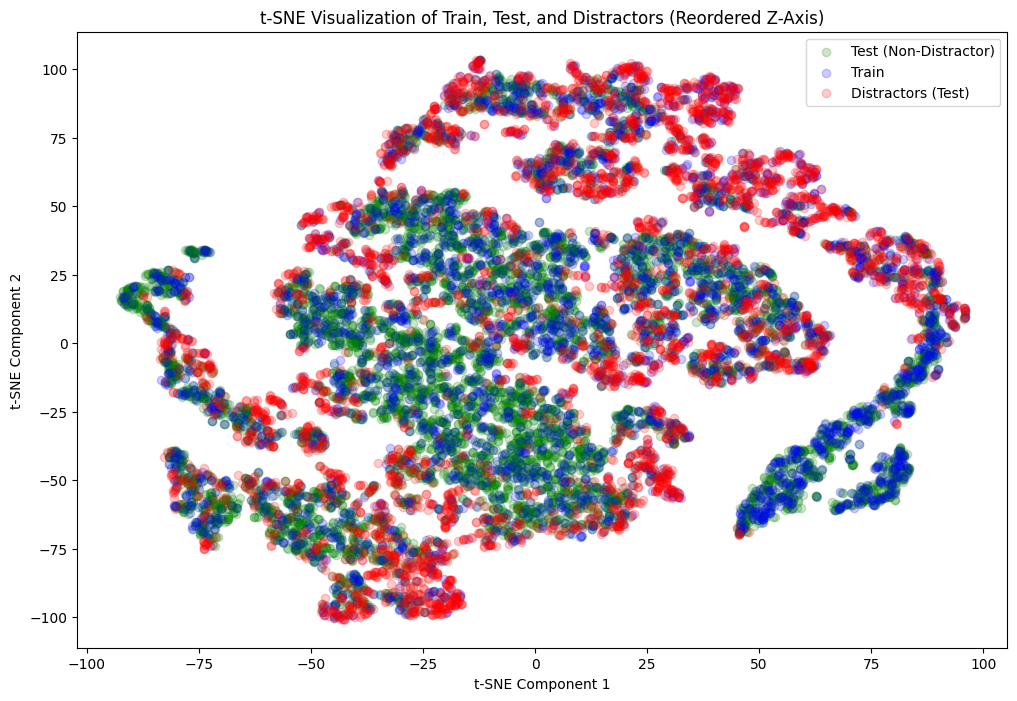

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch

# Step 3: Combine embeddings
train_labels = np.zeros(len(train_embeddings))
test_labels = np.ones(len(test_embeddings))

# Combine embeddings and labels
all_embeddings = torch.cat([train_embeddings, test_embeddings], dim=0).cpu().numpy()
all_labels = np.concatenate([train_labels, test_labels])

# Ensure distractor mask aligns with test embeddings
distractor_test_labels = np.concatenate([np.zeros(len(train_labels)), distractor_mask_a])

# Step 4: Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(all_embeddings)

# Step 5: Visualize
plt.figure(figsize=(12, 8))

# Plot test embeddings in the background
test_indices = np.where((all_labels == 1) & (distractor_test_labels == 0))
plt.scatter(tsne_results[test_indices, 0], tsne_results[test_indices, 1], 
            c="green", label="Test (Non-Distractor)", alpha=0.2, zorder=1)

# Plot train embeddings in the middle
train_indices = np.where(all_labels == 0)
plt.scatter(tsne_results[train_indices, 0], tsne_results[train_indices, 1], 
            c="blue", label="Train", alpha=0.2, zorder=2)

# Plot distractors on top
distractor_test_indices = np.where((all_labels == 1) & (distractor_test_labels == 1))
plt.scatter(tsne_results[distractor_test_indices, 0], tsne_results[distractor_test_indices, 1], 
            c="red", label="Distractors (Test)", alpha=0.2, zorder=3)

plt.title("t-SNE Visualization of Train, Test, and Distractors (Reordered Z-Axis)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.show()

In [64]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import pandas as pd
import numpy as np

# Step 4: Predict top-5 classes for non-distractors (Cosine Similarity) in batches
def predict_top_5_with_distractors_batched(image_embeddings, class_embeddings, distractor_indices, test_file_ids, class_indices, batch_size=64):
    predictions = {}

    # Ensure distractor_indices is processed correctly (flattened array)
    distractor_set = set(distractor_indices[0])  # Extract the array from the tuple
    distractor_mask = np.zeros(len(test_file_ids), dtype=bool)
    distractor_mask[list(distractor_set)] = True  # Create boolean mask for distractors

    # Ensure embeddings are on the same device
    device = image_embeddings.device
    class_embeddings = class_embeddings.to(device)

    # Process in batches
    for batch_start in tqdm(range(0, len(test_file_ids), batch_size), desc="Processing Batches"):
        batch_end = min(batch_start + batch_size, len(test_file_ids))
        batch_indices = range(batch_start, batch_end)

        # Extract batch data
        batch_embeddings = image_embeddings[batch_start:batch_end]
        batch_distractor_mask = distractor_mask[batch_start:batch_end]
        batch_file_ids = test_file_ids[batch_start:batch_end]

        # Compute cosine similarity for the batch
        similarities = F.cosine_similarity(batch_embeddings.unsqueeze(1), class_embeddings.unsqueeze(0), dim=2)

        # Generate predictions for the batch
        for i, file_id in enumerate(batch_file_ids):
            # Get top-5 classes based on similarity
            top5_indices = torch.topk(similarities[i], 5).indices.tolist()  # Top 5 from class embeddings
            top5_classes = [class_indices[j] for j in top5_indices]

            if batch_distractor_mask[i]:  # If distractor, prepend -1
                predictions[file_id] = [-1] + top5_classes[:4]
            else:  # Otherwise, just top-5 predictions
                predictions[file_id] = top5_classes

    return predictions

# Generate a mapping from class embeddings to their corresponding classes
class_indices = train_df['class'].values

# Step 5: Generate predictions using batch processing
batch_size = 512  # Adjust batch size to your memory constraints
distractor_indices = np.where(distractor_mask_a == 1)  # Ensure distractor_mask_a exists
test_predictions = predict_top_5_with_distractors_batched(
    test_embeddings,
    train_embeddings,
    distractor_indices,
    test_file_ids,
    class_indices,
    batch_size=batch_size
)

# Step 6: Save predictions for Kaggle submission
submission = []
for file_id, preds in test_predictions.items():
    submission.append({"file_id": file_id, "class": " ".join(map(str, preds))})

submission_df = pd.DataFrame(submission)

submission_file_path = "/kaggle/working/submission.csv"
submission_df.to_csv(submission_file_path, index=False)

print(f"Kaggle submission file saved to: {submission_file_path}")


Processing Batches: 100%|██████████| 26/26 [03:42<00:00,  8.57s/it]

Kaggle submission file saved to: /kaggle/working/submission.csv


In [65]:
submission_df

,file_id,class
0,837195b39a0c5a614325aebe9abb5c7f,588 458 943 538 567
1,e80e94dc4706c1eb704bbbc94ed3630e,1171 124 210 1084 891
2,2851ec4129446146c0e6f5e9125e9bb2,593 447 503 426 597
3,ef6e46d5c504dca95f8db3b6ae382bf4,748 979 1011 968 1072
4,ad7b7cc495dfc1e6beb19397c7de8b5e,-1 717 176 68 690
...,...,...
13110,b702858cf32fefac66b98fb3647c62fd,-1 202 1188 989 1042
13111,90393581e695a22454956cdcadd78fb4,1178 228 237 1179 958
13112,cdd59b15375cb54ffedac2b9b26a4969,61 222 1113 376 378
13113,d23e45904aaea8ec3ebf670e586bc849,327 1053 1184 785 213


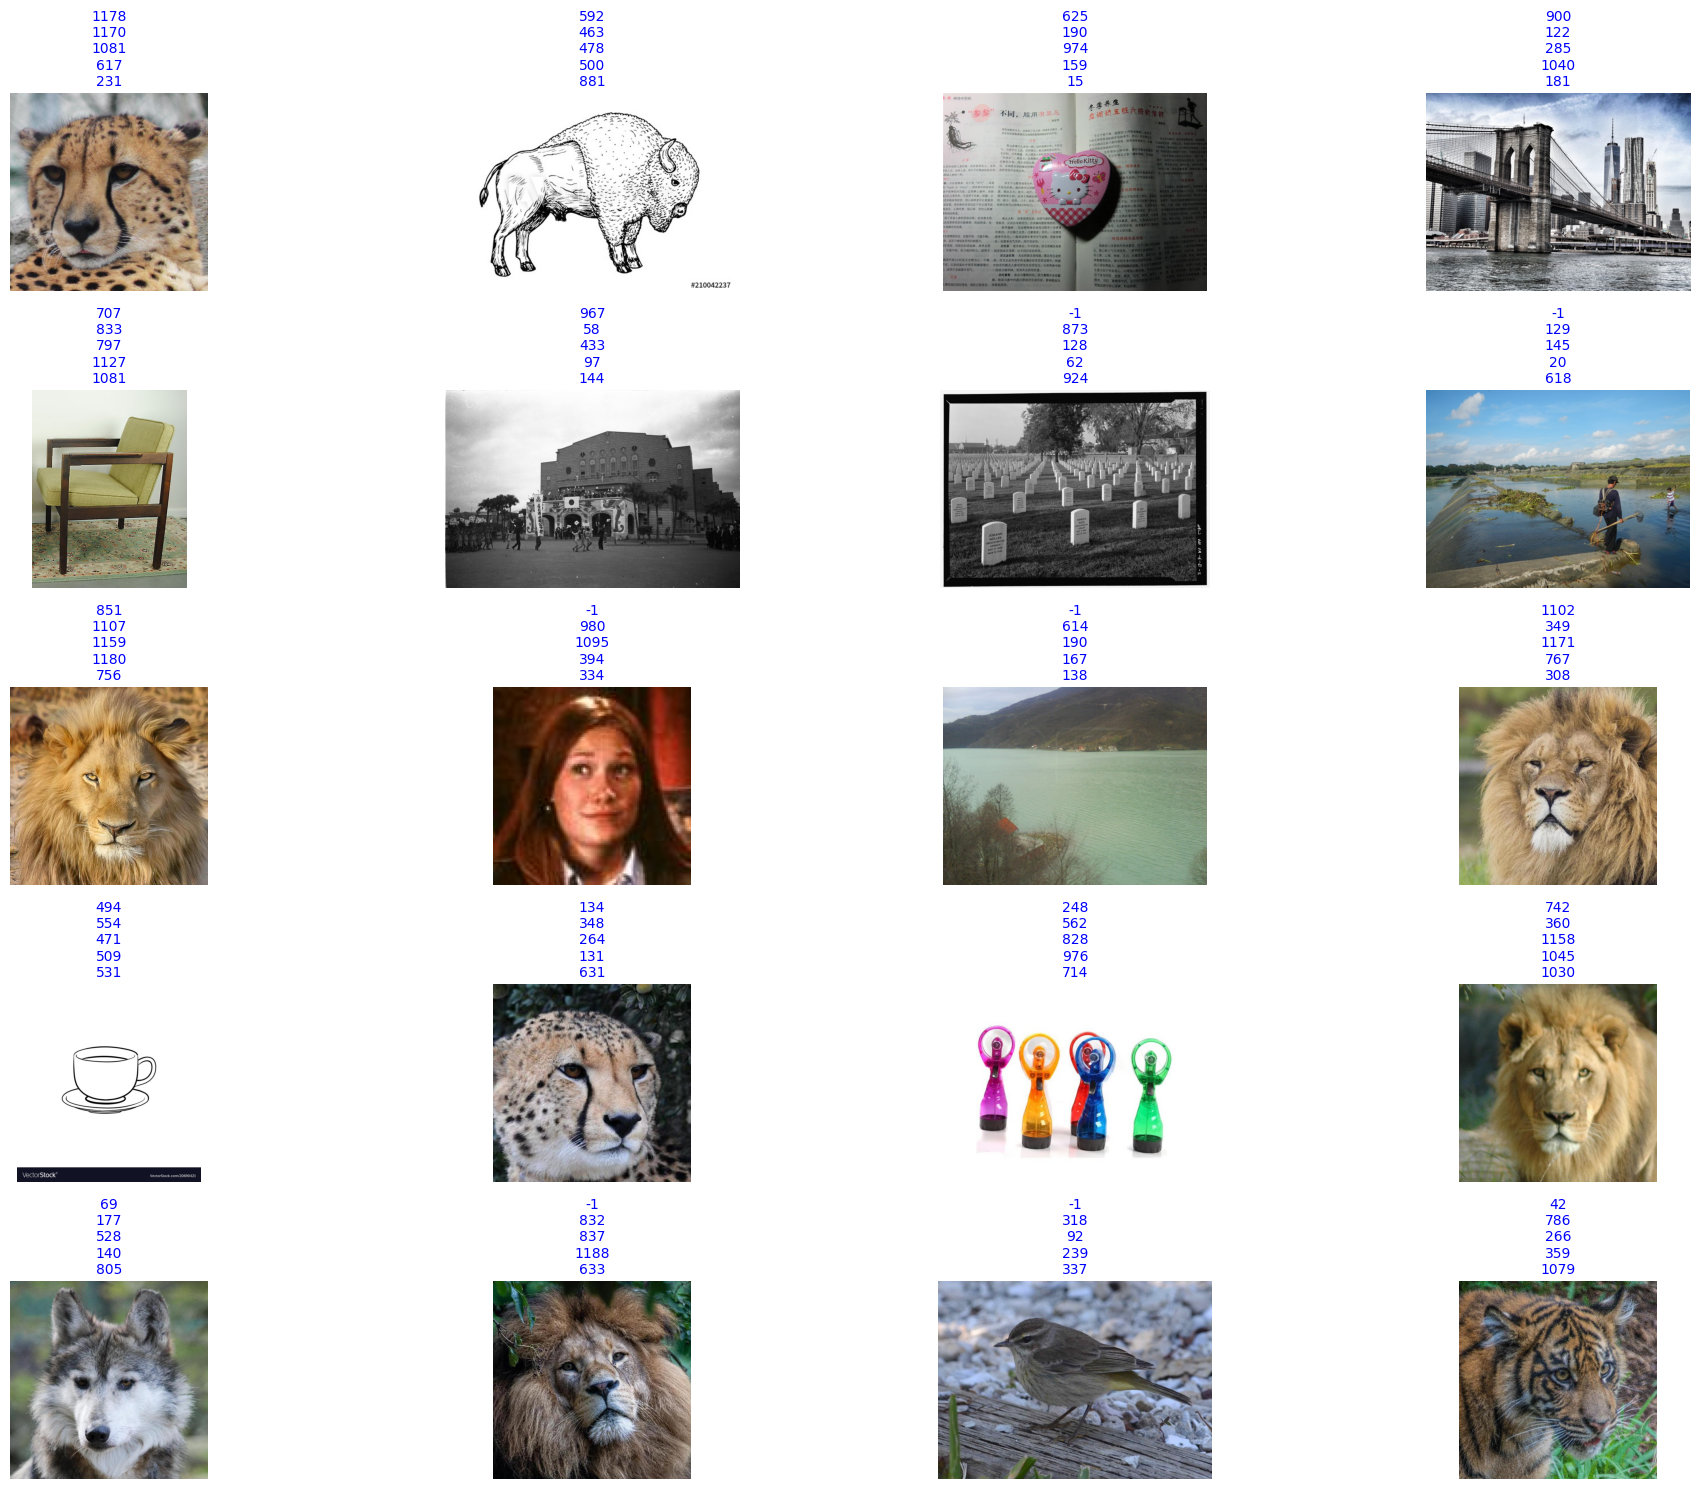

In [66]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import os

def visualize_predictions(df, img_dir, grid_shape=(5, 4)):
    num_samples = grid_shape[0] * grid_shape[1]
    sampled = df.sample(num_samples)

    fig, axes = plt.subplots(*grid_shape, figsize=(20, 15))
    axes = axes.flatten()

    for ax, (_, row) in zip(axes, sampled.iterrows()):
        img_path = os.path.join(img_dir, f"{row['file_id']}.jpg")
        try:
            image = Image.open(img_path).convert("RGB")
            ax.imshow(image)
            ax.axis('off')
            ax.set_title(row['class'].replace(" ", "\n"), fontsize=10, color='blue')
        except Exception as e:
            ax.axis('off')
            ax.set_title("Error", fontsize=10, color='red')
    
    plt.tight_layout()
    plt.show()

# Example Usage
visualize_predictions(
    submission_df, 
    "/kaggle/input/ucu-computer-vision-2024/test"
)
